# A simple temporal data assimilation example

## J Gómez-Dans

### Introduction

We deal here with a problem where we have a time series of observations of the state (so the observation operator is identity), a broad prior on the state, and eventually, a regularisation or smoother model.

We first define the state

### The state

Crucial to our effort is the definition of the state of the system. This is the quantity of interest: an estimate of the state given all the observations, their limitations and as much additional information we might have. In EOLDAS, the `State` class is the basic building block: it defines the state, allows us to collect the information containers for all the other pieces of information, and it allows us to combine things optimally. The `State` requires some initialisation:

1. a `state_config` dictionary. This dictionary has keys for each of the elements of the state (these could be e.g. temperature, leaf area index, turbidity...). Each entry is associated one key (defined in `eoldas_ng`: `FIXED`, `CONSTANT` or `VARIABLE`. The first indicates that a given value is used for that particular part of the state (i.e., we assume that the parameter is known and prescribed). `CONSTANT` indicates that in a dynamic (temporal or spatial) problem, the state has a single scalar representation of that particular variable (i.e., all time periods share the same value of this parameter, as with `FIXED`, but now we are actually *solving* for it). Finally, `VARIABLE` is interpreted as solving for a value of the parameter for each time or space position.
2. a `state_grid` array that defines the topology of the problem. It could be a one-dimensional array with the times we will estimate the state, or a 2D array that defines a grid on which the state is defined spatially, for example.
3. a `default_values` dictionary that sets for each parameter the default values (i.e., the ones that will substituted for in a `FIXED` parameter).

In Python, we do this as follows:

In [18]:
# The following imports are typically done by default
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from s2_example_funcs import plot_config, pretty_axes
from collections import OrderedDict
from eoldas_ng import *
plot_config()
state_config = { 'magnitude': VARIABLE } # We solve for a parameter called 'magnitude'
default_values = { 'magnitude': 0.5 } # The default value is 0.5 but since it's defined
                                      # as VARIABLE above, this definition has no effect
parameter_min = OrderedDict ()
parameter_max = OrderedDict ()
parameter_min [ 'magnitude' ] = 0.
parameter_max [ 'magnitude' ] = 1.
state_grid = np.arange ( 1, 366 ) # A daily time series with 1 day sampling

# Now, just define the state
the_state = State ( state_config, state_grid, default_values, parameter_min, \
                   parameter_max)


Saving results to eoldas_retval_20150826_160601_cubil.pkl


### The data

Let's assume that we have an annual time series of a given *magnitude*. It could be anything that changes slowly with time. Something like the temporal trajectory of a vegetation index. Typically, these are smooth, as the phenomena that drive the signal (vegetation development, etc.) change slowly and continously. In the case of a vegetation index, missing observations will happen because of orbital considerations, and also due to observational availability (cloud cover, nighttime overpasses, etc.). Let's write a Python function to create some synthetic data

In [12]:
def dbl_logistic_model ( p, x ):
    """A double logistic model, as in Sobrino and Juliean, or Zhang et al"""
    return p[0] + p[1]* ( 1./(1+np.exp(p[2]*(x-p[3]))) + \
                          1./(1+np.exp(-p[4]*(x-p[5])))  - 1 )
def create_data ( sigma_obs ):
    """Creates a 365-step long observations, contaminated with 
    additive Gaussian iid noise of standard deviation `sigma_obs`. 
    Random observations will be dropped by setting `obs_mask` to 
    `False`. We return the time axis, the original "clean" data, the
    noisy observations and the observation mask."""
    x = np.arange(1,366 )
    y_smooth = dbl_logistic_model ( [0.1, 0.85, -0.1, 60, -0.05, 240], x )
    y_noisy = y_smooth + np.random.randn(365)*sigma_obs
    obs_mask = np.random.rand(x.shape[0])
    obs_mask = np.where ( obs_mask > 0.9, True, False )

    return ( x, y_smooth, y_noisy, obs_mask )



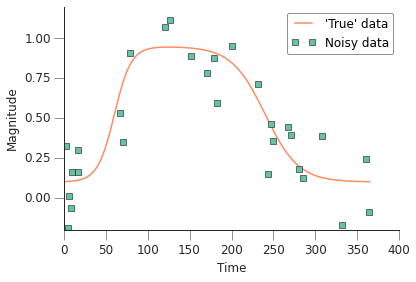

In [15]:
sigma_obs = 0.15 # Observational uncertainty
( x, y_smooth, y_noisy, obs_mask ) = create_data ( sigma_obs )
plt.plot ( x, y_smooth, '-', lw=1.5, label="'True' data")
yN = np.ma.array ( y_noisy, mask=~obs_mask)
plt.plot ( x, yN, 's', label="Noisy data" )
plt.xlabel ("Time")
plt.ylabel("Magnitude")
plt.legend(loc='best')
pretty_axes(plt.gca())

Now, we need to define an `Operator` for dealing with the data. Typically, if we assume (like here) that data are corrupted by Gaussian iid noise of variance $\sigma^2$, the *minus loglikelihood function* is given by 
$$
J_{obs} = -\frac{1}{2}\left( \mathbf{y} - \mathcal{H}(\mathbf{x})\right)^{T}\mathbf{C}_{obs}^{-1}\left( \mathbf{y} - \mathcal{H}(\mathbf{x})\right),
$$
where

$\mathbf{x}$
    is the state vector

$\mathbf{y}$
    is the observations vector. If a observation is missing, it does not contribute to this term.

$\mathbf{C}_{obs}^{-1}$
    is the inverse covariance matrix of the observations.

$\mathcal{H}(\mathbf{x})$
    is the observation operator. This operator allows us to map the state vector into the vector of the observations (for example, you might want to use some radiative transfer model to map from LAI, etc. to albedo or radiance).

A way of understanding this term is that we want to reduce the difference between $\mathbf{y}$ and $\mathcal{H}(\mathbf{x})$, so they agree, but always modulated by how much trust we put in the observations (the covariance matrix). In code:

In [19]:
the_observations = ObservationOperator ( state_grid, y_noisy, sigma_obs, obs_mask)

The `Operator` classes are special because they have two specific functions:  `der_cost` and `der_der_cost`. The former calculates $J_{obs}$ as above, but also its partial derivatives (the Jacobian). `der_der_cost` calculates the Hessian (second order partial derivatives matrix). We'll see why later. It is expected that the user will be able to subclass the original classes and adapt them to her circumstances.

In this particular case, $\mathcal{H}(\mathbf{x})$ is the identity operator ($\mathcal{H}(\mathbf{x})=\mathbf{x}$, but others might be required. Note that for the calculation of derivatives, the derivatives of $\mathcal{H}(\mathbf{x})$ will be required. If not available, they can be evaluated numerically.

`the_observations` now contains the information on the observations. We add this to `the_state`, using the `add_operator` method. This method takes a string for the name of the cost function (will be used for logging later, not yet implemented), and the operator itself:

In [20]:
the_state.add_operator ( "Observations", the_observations )
    

We can now "solve" this simple problem (in fact, this is the maximum likelihood approach), and minimise $J_{obs}$. The problem is that our data is noisy and incomplete, and therefore, the solution would be undefined for points with no observations. But as an example of how it works, it's useful. 
Basically, the procedure will minimise $J_{obs}$. This minimisation will be done efficiently using an optimiser that follows the partial derivatives to *descend* to the lowest point in the cost function (that's why the partial derivatives are required), or at least the point where the partial derivatives are 0 that are close to a given starting point.
To minimise, we need to give the minimiser a starting point. You can choose whatever you want. A good starting point makes the minimisation faster, and might avoid local minima being selected to the detriment of a global minimum. Let's start with the true value, so we can take a look at how this works:

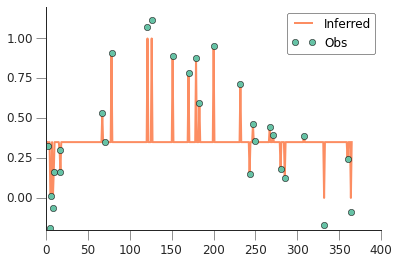

In [23]:
retval = the_state.optimize(x0={'magnitude':np.ones(365)*0.35 })
plt.plot ( x, retval['real_map']['magnitude'], '-', label="Inferred")
plt.plot(x, yN, 'o', label="Obs")
plt.legend(loc='best')
pretty_axes(plt.gca())

What's happened here? As we start with the correct answer, where there are no observations, this is retained. But whenever we get observations, we inmediately see how the state moves towards them, because all we are doing is trying to minimise the distance between one point in the curve and the observations. There's no other constraint. Also note that if the observations go above 1 or below 0 (the upper and lower boundary for the optimisation), the optimiser does not allow the state to fit the observations perfectly.

What is interesting is to note that this solution is quite spiky: it's got the right shape (because we provided the exact true values where there are no observations), but we inmediately see that this jaggedness is unnatural in a slow-evolving system: smooth transitions are to be expected. This high frquency noise is usually smoothed out using filtering or smoothing techniques. 

Now, let's put everything together: the prior, the "dynamic model" (or smoother) and the observations:

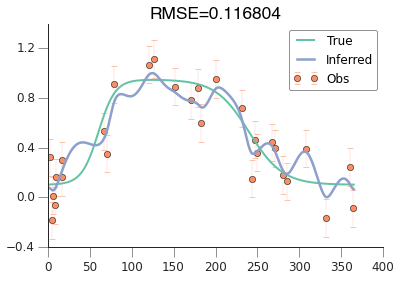

In [24]:
#######################################################
####   
#### Set the prior up!
####
#######################################################

mu_prior = { 'magnitude': np.array([0.5]) }
inv_cov_prior = { 'magnitude': np.array([1./(2*2)]) }
the_prior = Prior ( mu_prior, inv_cov_prior ) # Uninformative prior
#######################################################
####   
#### Set the model up!
####
#######################################################
the_model = TemporalSmoother ( state_grid, 5e3, required_params=["magnitude"] )

#######################################################
####   
#### Add the prior and the smoother to the state
#### Remember we had added the observations already before
####
#######################################################

the_state.add_operator ( "Prior", the_prior )
the_state.add_operator ( "Model", the_model )

# Plot the observations and the "truth"
plt.errorbar(x, yN, yerr=sigma_obs, fmt='o', lw=0.2, \
             label="Obs")
plt.plot ( x, y_smooth, '-', label="True")

# Estimate the state, starting from a random estimate
retval = the_state.optimize( np.random.rand(y_smooth.size) )

# Plot the results!
plt.plot ( x, retval['real_map']['magnitude'], '-', lw=2.5, label="Inferred")
plt.legend(loc='best')
plt.title("RMSE=%f" % ( np.std ( y_smooth - retval['real_map']['magnitude'] ) ) )

pretty_axes(plt.gca())

So we see that for a suitable value of the regularisation constant, we get a reasonable reconstruction of the underlying trend. Note how this breaks down for the first sample, as edge effects take precedence here and the first sample is just assumed to be the prior value of 0.5.

But what about if we had some prior idea of how the annual trajectory of our magnitude looks like? For example, we might guess that it follows some particular trend, with uncertainty on it:

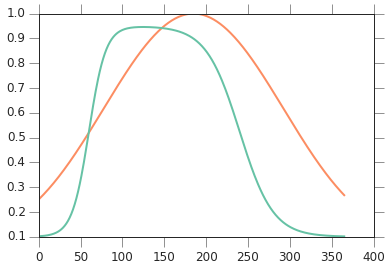

In [25]:
y_prior = 0.1 + 0.9 * np.sin(np.pi*(x+180)/(365*2.))**5
plt.plot(x, y_prior )
plt.plot ( x,  dbl_logistic_model ( [0.1, 0.85, -0.1, 60, -0.05, 240], x ))

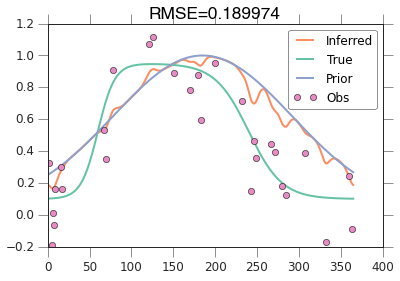

In [26]:
mu_prior = { 'magnitude': y_prior }
inv_cov_prior = { 'magnitude': np.array([1./(0.2*0.2)]) }
the_prior = Prior ( mu_prior, inv_cov_prior ) # Uninformative prior
the_model = TemporalSmoother ( state_grid, gamma=5e3, required_params=["magnitude"] )
the_state.add_operator ( "Prior", the_prior )
the_state.add_operator ( "Model", the_model )


retval = the_state.optimize( y_smooth )
plt.plot ( x, retval["real_map"]["magnitude"], '-', label="Inferred")
plt.plot ( x, y_smooth, '-', label="True")
plt.plot(x, y_prior, '-', label="Prior" )
plt.plot(x, yN, 'o', label="Obs")
plt.legend(loc='best')
plt.title("RMSE=%f" % ( np.std ( y_smooth - retval["real_map"]["magnitude"] ) ) )


The previous case shows that we have a lot of trust in the prior (the standard deviation was set to 0.2, a fairly tight value). In fact, the fit is worse than having the very broad prior we started with (stating basically ignorance). Let's loosen it a bit, but also note that the data look a bit noisy, suggesting that we  need to require more smoothing, controlled by pulling `gamma` in `the_model` up:

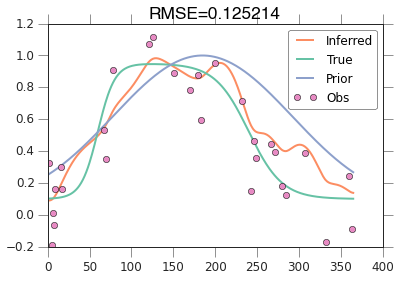

In [27]:
mu_prior = { 'magnitude': y_prior }
inv_cov_prior = { 'magnitude': np.array([1./(0.6*0.6)]) }
the_prior = Prior ( mu_prior, inv_cov_prior ) # Uninformative prior
the_model = TemporalSmoother ( state_grid, gamma=5e4, required_params=["magnitude"] )
the_state.add_operator ( "Prior", the_prior )
the_state.add_operator ( "Model", the_model )


retval = the_state.optimize( y_smooth )
plt.plot ( x, retval["real_map"]["magnitude"], '-', label="Inferred")
plt.plot ( x, y_smooth, '-', label="True")
plt.plot(x, y_prior, '-', label="Prior" )
plt.plot(x, yN, 'o', label="Obs")
plt.legend(loc='best')
plt.title("RMSE=%f" % ( np.std ( y_smooth - retval["real_map"]["magnitude"] ) ) )

So we get a better fit now than we started with, althought not that great!! And we tweaked things by hand!!

## Uncertainty

The uncertainty is calculated by the system and stored in `retval`. For simplicity, we'll use the 5-95% CI:

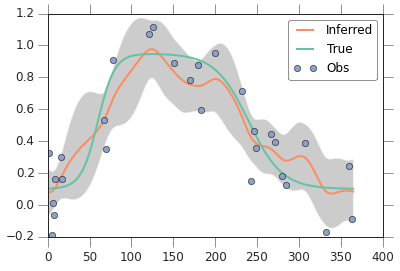

In [30]:
import scipy.sparse as sp
mu_prior = { 'magnitude': np.array([0.5]) }
inv_cov_prior = { 'magnitude': sp.lil_matrix ( np.diag(np.random.rand(365)))}#np.array([1./(2*2)]) }
the_prior = Prior ( mu_prior, inv_cov_prior ) # Uninformative prior
the_model = TemporalSmoother ( state_grid, gamma=5e4, required_params=["magnitude"] )
the_state.add_operator ( "Prior", the_prior )
the_state.add_operator ( "Model", the_model )


retval = the_state.optimize( y_smooth, do_unc=True )

plt.fill_between ( x, retval['real_ci5pc']['magnitude'], \
                  retval['real_ci95pc']['magnitude'],facecolor="0.8")
plt.plot ( x, retval["real_map"]["magnitude"], '-', label="Inferred")
plt.plot ( x, y_smooth, '-', label="True")
plt.plot(x, yN, 'o', label="Obs")

plt.legend(loc='best')

Now, going back to our original prior, we find that our error region covers nearly the true value over the entire series. The small miss at the end suggests that we are smoothing too much, or in other words, we believe too much in the expectation of smoothness. Let's try a lower value of `gamma`...

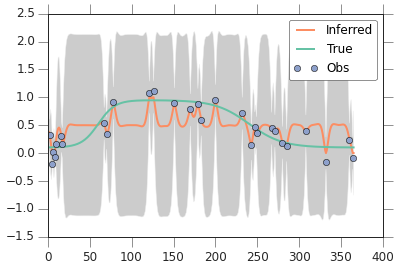

In [31]:
mu_prior = { 'magnitude': np.array([0.5]) }
inv_cov_prior = { 'magnitude': np.array([1./(2*2)]) }
the_prior = Prior ( mu_prior, inv_cov_prior ) # Uninformative prior
the_model = TemporalSmoother ( state_grid, gamma=5, required_params=["magnitude"] )
the_state.add_operator ( "Prior", the_prior )
the_state.add_operator ( "Model", the_model )


retval = the_state.optimize( y_smooth, do_unc=True )

plt.fill_between ( x, retval['real_ci5pc']['magnitude'], \
                  retval['real_ci95pc']['magnitude'],facecolor="0.8")
plt.plot ( x, retval["real_map"]["magnitude"], '-', label="Inferred")
plt.plot ( x, y_smooth, '-', label="True")
plt.plot(x, yN, 'o', label="Obs")

plt.legend(loc='best')

## Finding the regularisation factor

In [32]:
def k_fold_cross_validation(X, K, randomise = False):
	"""
	Generates K (training, validation) pairs from the items in X.

	Each pair is a partition of X, where validation is an iterable
	of length len(X)/K. So each training iterable is of length (K-1)*len(X)/K.

	If randomise is true, a copy of X is shuffled before partitioning,
	otherwise its order is preserved in training and validation.
	"""
	if randomise: from random import shuffle; X=list(X); shuffle(X)
	for k in xrange(K):
		training = [x for i, x in enumerate(X) if i % K != k]
		validation = [x for i, x in enumerate(X) if i % K == k]
		yield training, validation
obs_locs = obs_mask.nonzero()[0]

gamma_vals = np.logspace( -2, 7, 15 )
xvaln = np.zeros (( 15, 5 ))
xvalt = np.zeros (( 15, 5 ))
jj = 0
for gamma in gamma_vals:
    the_model = TemporalSmoother ( state_grid, gamma=gamma, \
                                  required_params=["magnitude"] )
    the_state.add_operator ( "Model", the_model )
    print
    print gamma,
    ii = 0
    for t, v in k_fold_cross_validation( obs_locs, 5, randomise=True ):
        new_mask = obs_mask*1
        new_mask[v] = False
        the_observations = ObservationOperator ( state_grid, y_noisy, \
                                            sigma_obs, new_mask)
        the_state.add_operator( "Observations", the_observations )
        retval = the_state.optimize(x0={"magnitude":np.random.rand(365)})
        xx = retval['real_map']['magnitude'][v]
        xvalt[jj,ii] = np.std(y_smooth[v] - xx)
        xvaln[jj,ii] = np.std(y_noisy[v] - xx)
        print "%8.2f" % np.std(y_smooth[v] - xx),
        ii += 1
    jj += 1


0.01     0.36     0.16     0.34     0.29     0.32
0.0439397056076     0.12     0.32     0.31     0.11     0.29
0.193069772888     0.29     0.30     0.34     0.30     0.26
0.848342898244     0.26     0.26     0.27     0.29     0.30
3.72759372031     0.21     0.21     0.27     0.23     0.36
16.3789370695     0.28     0.27     0.11     0.16     0.25
71.9685673001     0.19     0.27     0.23     0.29     0.13
316.227766017     0.26     0.12     0.13     0.29     0.18
1389.49549437     0.29     0.09     0.18     0.19     0.20
6105.40229659     0.13     0.26     0.13     0.06     0.07
26826.9579528     0.14     0.16     0.06     0.09     0.24
117876.863479     0.20     0.20     0.11     0.06     0.09
517947.467923     0.20     0.13     0.32     0.09     0.13
2275845.92607     0.26     0.28     0.21     0.17     0.24
10000000.0     0.41     0.25     0.33     0.34     0.30


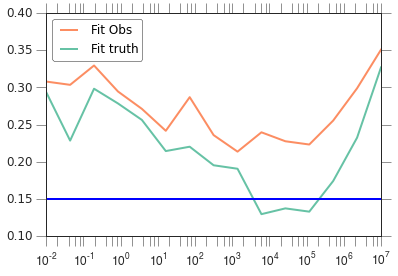

In [33]:
plt.semilogx (gamma_vals, np.array(xvaln).mean(axis=1), '-', label="Fit Obs")
plt.semilogx (gamma_vals, np.array(xvalt).mean(axis=1), '-', label="Fit truth")
plt.axhline(0.15)
plt.legend(loc='best')


In the above plot, we see that for both predicting the noisy observations (blue curve) and the actual truth (red curve), values around $10^3-10^4$ appear suitable. Note how the blue curve reaches the noise floor of 0.15. This is an important find. In a real case situation, the red curve would not exist, as the truth is unknown. We would only have access to the blue curve, and we would have to make sure that the average uncertainty in predicting noisy observations that were not included in the assimilation would have to be the noise component. In other words, we cannot do better than the standard we are as using as a reference!

Additionally, note that the problem we have solved is quite different: we are ignoring 20% of our observations and the comparing against them. This means that the cross-validation problem has been solved with 1/5 less evidence, which suggests that we can probably use a slightly larger value of `gamma` than the optimal one. 

Let's see how this looks like:

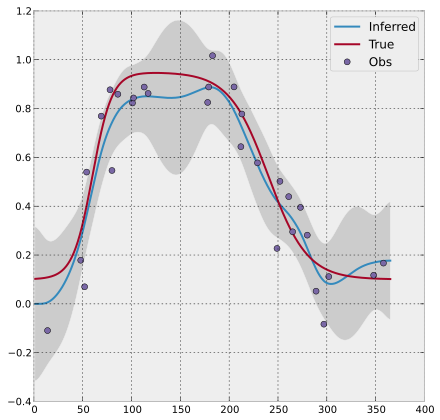

In [156]:
the_observations = ObservationOperator ( state_grid, y_noisy, sigma_obs, obs_mask)
the_state.add_operator ( "Observations", the_observations )
mu_prior = { 'magnitude': np.array([0.5]) }
inv_cov_prior = { 'magnitude': np.array([1./(2*2)]) }
the_prior = Prior ( mu_prior, inv_cov_prior ) # Uninformative prior
the_model = TemporalSmoother ( state_grid, gamma=1e5, required_params=["magnitude"] )
the_state.add_operator ( "Prior", the_prior )
the_state.add_operator ( "Model", the_model )


retval = the_state.optimize( y_smooth, do_unc=True )
plt.fill_between ( x, retval['real_ci5pc']['magnitude'], \
                  retval['real_ci95pc']['magnitude'],facecolor="0.8")
plt.plot ( x, retval["real_map"]["magnitude"], '-', label="Inferred")
plt.plot ( x, y_smooth, '-', label="True")
plt.plot(x, yN, 'o', label="Obs")

plt.legend(loc='best')

The result is acceptable (the value of gamma is similar to the ones used earlier). We see that some observations are not well modelled, but the truth curve is within the uncertainty area. 